**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
!ls /content/gdrive/My\ Drive/"DL Notebooks"/"Skin cancer ISIC The International Skin Imaging Collaboration"


Test  Train


In [41]:
# Defining the path for train and test images
# Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/My Drive/DL Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/DL Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test')


In [42]:
# Printing the count of images in each directory
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train images:\t", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test images:\t", image_count_test)

Train images:	 2239
Test images:	 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180
num_classes = 9

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset , size = 80%, resizing the image to 180X180
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset, size = 20%, resizing the image to 180X180
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

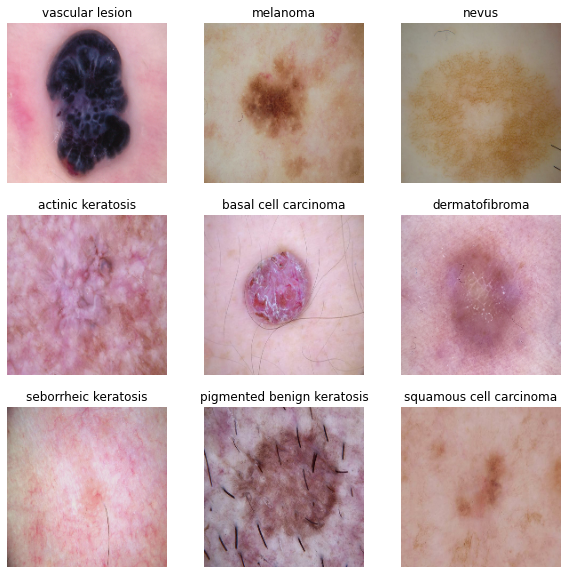

In [43]:
plt.figure(figsize=(10, 10))
class_list = []
j=0
for images, labels in train_ds.take(1):
  for i in range(image_count_train):
    if class_names[labels[i%32]] not in class_list and j<9:
      ax = plt.subplot(3, 3, j + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i%32]])
      class_list.append(class_names[labels[i%32]])
      plt.axis("off")
      j=j+1
    elif j>=9:
      break


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compile the model
Choose an appropriate optimiser and loss function for model training 

In [13]:
### Todo, choose an appropriate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 109s 1s/step - loss: 2.0158 - accuracy: 0.2667 - val_loss: 1.7334 - val_accuracy: 0.4116
Epoch 2/20
56/56 [==============================] - 3s 45ms/step - loss: 1.6632 - accuracy: 0.4068 - val_loss: 1.5990 - val_accuracy: 0.4206
Epoch 3/20
56/56 [==============================] - 2s 43ms/step - loss: 1.4887 - accuracy: 0.4782 - val_loss: 1.4425 - val_accuracy: 0.5101
Epoch 4/20
56/56 [==============================] - 2s 43ms/step - loss: 1.3897 - accuracy: 0.5151 - val_loss: 1.4100 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 2s 43ms/step - loss: 1.3138 - accuracy: 0.5430 - val_loss: 1.3629 - val_accuracy: 0.5257
Epoch 6/20
56/56 [==============================] - 2s 43ms/step - loss: 1.2136 - accuracy: 0.5686 - val_loss: 1.3483 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 2s 43ms/step - loss: 1.1364 - accuracy: 0.5887 - val_loss: 1.3092 - val_accuracy: 0.5459
Epoch 8/20
56

### Visualizing training results

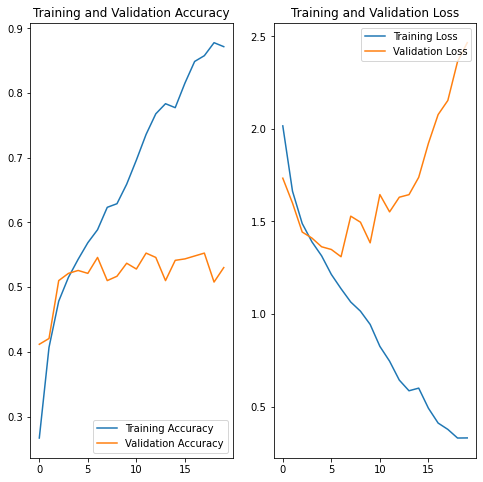

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit



*   The model looks to be overfitting as the accuracy on the training set is 87% and on validate set is 53%



In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable — a sign of overfitting.

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

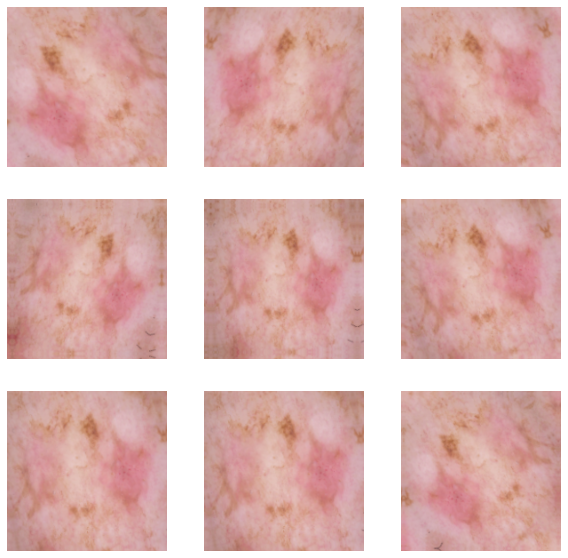

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [20]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 55ms/step - loss: 2.0797 - accuracy: 0.2154 - val_loss: 1.9361 - val_accuracy: 0.2931
Epoch 2/20
56/56 [==============================] - 3s 49ms/step - loss: 1.8998 - accuracy: 0.2885 - val_loss: 1.8854 - val_accuracy: 0.3020
Epoch 3/20
56/56 [==============================] - 3s 49ms/step - loss: 1.8326 - accuracy: 0.3158 - val_loss: 1.7075 - val_accuracy: 0.4139
Epoch 4/20
56/56 [==============================] - 3s 49ms/step - loss: 1.6576 - accuracy: 0.4090 - val_loss: 1.5029 - val_accuracy: 0.4787
Epoch 5/20
56/56 [==============================] - 3s 49ms/step - loss: 1.4581 - accuracy: 0.4704 - val_loss: 1.3945 - val_accuracy: 0.5101
Epoch 6/20
56/56 [==============================] - 3s 49ms/step - loss: 1.3845 - accuracy: 0.5100 - val_loss: 1.4775 - val_accuracy: 0.4765
Epoch 7/20
56/56 [==============================] - 3s 49ms/step - loss: 1.3757 - accuracy: 0.5123 - val_loss: 1.4112 - val_accuracy: 0.4989
Epoch 8/20
56

### Visualizing the results

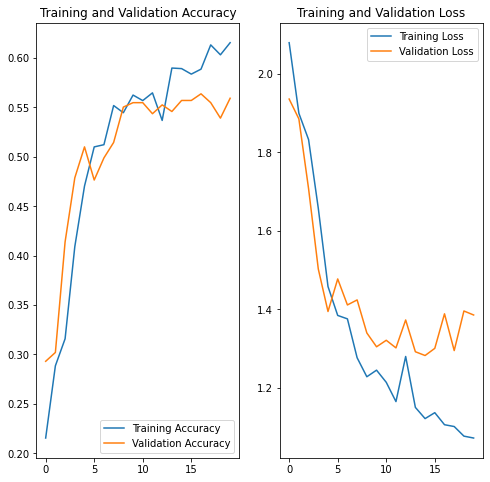

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

There is no sign of model overfitting now as the difference between traing and validation accuracies is not very high as compared to the previous model. The performance has gone down.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [24]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/My Drive/DL Notebooks/Skin can...,nevus
1,/content/gdrive/My Drive/DL Notebooks/Skin can...,nevus
2,/content/gdrive/My Drive/DL Notebooks/Skin can...,nevus
3,/content/gdrive/My Drive/DL Notebooks/Skin can...,nevus
4,/content/gdrive/My Drive/DL Notebooks/Skin can...,nevus
...,...,...
2234,/content/gdrive/My Drive/DL Notebooks/Skin can...,pigmented benign keratosis
2235,/content/gdrive/My Drive/DL Notebooks/Skin can...,pigmented benign keratosis
2236,/content/gdrive/My Drive/DL Notebooks/Skin can...,pigmented benign keratosis
2237,/content/gdrive/My Drive/DL Notebooks/Skin can...,pigmented benign keratosis


Class=4, n=357 (15.945%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=0, n=114 (5.092%)
Class=8, n=139 (6.208%)
Class=3, n=438 (19.562%)
Class=2, n=95 (4.243%)
Class=1, n=376 (16.793%)
Class=5, n=462 (20.634%)


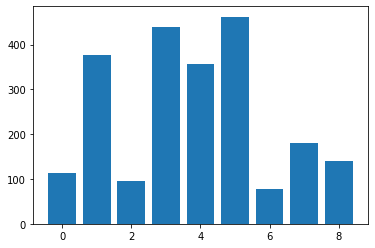

In [25]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

#### **Todo:** Write your findings here: 
#### - Class 6 has least number of images
#### - classes 1,3,4,5 are dominating the data in terms proportionate number of samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
#path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
path_to_training_dataset="/content/gdrive/My Drive/DL Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/DL Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBF9BB25890>: 100%|██████████| 500/500 [00:23<00:00, 21.15 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/DL Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBF2912EA50>: 100%|██████████| 500/500 [00:22<00:00, 22.27 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/DL Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBF2916FE90>: 100%|██████████| 500/500 [00:23<00:00, 21.11 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/DL Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBF9BA32ED0>: 100%|██████████| 500/500 [01:57<00:00,  4.25 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/DL Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0x7FBF2916FA90>: 100%|██████████| 500/500 [01:35<00:00,  5.23 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/DL Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBF9BB0EED0>: 100%|██████████| 500/500 [00:23<00:00, 21.45 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/DL Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBF9BB25B90>: 100%|██████████| 500/500 [00:53<00:00,  9.33 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/DL Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBF29202550>: 100%|██████████| 500/500 [00:23<00:00, 21.41 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/DL Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC0B3B50350>: 100%|██████████| 500/500 [00:23<00:00, 21.17 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/My Drive/DL Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000541.jpg_9b463f5e-7e8c-48e6-b3a0-0ceaf87b95de.jpg',
 '/content/gdrive/My Drive/DL Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026650.jpg_899c0ea6-6b85-407a-bacc-cfbb7efc4af7.jpg',
 '/content/gdrive/My Drive/DL Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000364.jpg_9c488e2e-e657-4c39-9201-e96eac35ce39.jpg',
 '/content/gdrive/My Drive/DL Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0025953.jpg_5dbc5775-5e15-4576-9c26-a9abb25ad2c7.jpg',
 '/content/gdrive/My Drive/DL Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000343.jpg_5f1b1cb8-63db-4ad4-aa0c-4ac84951731f.jpg',
 '/content/gdrive/My

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [31]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [32]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [33]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [35]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [37]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [38]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [39]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 46s 90ms/step - loss: 1.8687 - accuracy: 0.2789 - val_loss: 1.6036 - val_accuracy: 0.4388
Epoch 2/30
169/169 [==============================] - 7s 43ms/step - loss: 1.4758 - accuracy: 0.4434 - val_loss: 1.4238 - val_accuracy: 0.4595
Epoch 3/30
169/169 [==============================] - 7s 43ms/step - loss: 1.2509 - accuracy: 0.5323 - val_loss: 1.2052 - val_accuracy: 0.5694
Epoch 4/30
169/169 [==============================] - 7s 43ms/step - loss: 1.0565 - accuracy: 0.6083 - val_loss: 1.0492 - val_accuracy: 0.6244
Epoch 5/30
169/169 [==============================] - 7s 43ms/step - loss: 0.9078 - accuracy: 0.6740 - val_loss: 0.9544 - val_accuracy: 0.6511
Epoch 6/30
169/169 [==============================] - 7s 43ms/step - loss: 0.7552 - accuracy: 0.7350 - val_loss: 1.0593 - val_accuracy: 0.6281
Epoch 7/30
169/169 [==============================] - 7s 43ms/step - loss: 0.6084 - accuracy: 0.7856 - val_loss: 0.9060 - val_accuracy: 0.692

#### **Todo:**  Visualize the model results

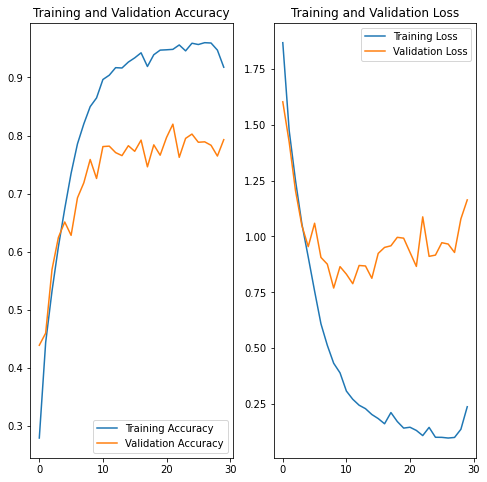

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

- The model Performance has improved as compared to previous models but still there is a scope for improvement as the model is not performing too well on validation data set
- Class rebalancing did help in terms of improving the accuracies and reducing the losses
